All dataset lengths (should be 7080): 7080
Logistic Regression
20% - Accuracy: 0.9417
40% - Accuracy: 0.9579
60% - Accuracy: 0.9647
80% - Accuracy: 0.9725
100% - Accuracy: 0.9725
Random Forest
20% - Accuracy: 0.9543
40% - Accuracy: 0.9699
60% - Accuracy: 0.9753
80% - Accuracy: 0.9809
100% - Accuracy: 0.9809
XGBoost
20% - Accuracy: 0.9536
40% - Accuracy: 0.9649
60% - Accuracy: 0.9686
80% - Accuracy: 0.9718
100% - Accuracy: 0.9718


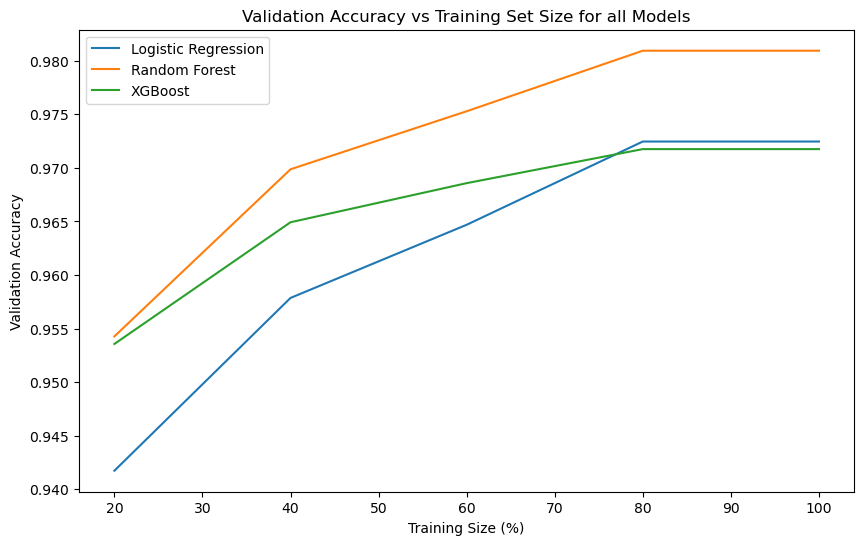

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

t_em_df = pd.read_csv("datasets/train/train_emoticon.csv")
t_em_X = t_em_df['input_emoticon'].tolist()
t_em_Y = t_em_df['label'].tolist()

test_em_df = pd.read_csv("datasets/valid/valid_emoticon.csv")
test_em_X = test_em_df['input_emoticon'].tolist()

t_seq_df = pd.read_csv("datasets/train/train_text_seq.csv")
t_seq_X = t_seq_df['input_str'].tolist()
t_seq_Y = t_seq_df['label'].tolist()

test_seq_df = pd.read_csv("datasets/valid/valid_text_seq.csv")
test_seq_X = test_seq_df['input_str'].tolist()

t_f = np.load("datasets/train/train_feature.npz", allow_pickle=True)
t_f_X = t_f['features']
t_f_Y = t_f['label']

test_feat = np.load("datasets/valid/valid_feature.npz", allow_pickle=True)
test_feat_X = test_feat['features']

min_len = min(len(t_em_X), len(t_seq_X), len(t_f_X))
print(f"All dataset lengths (should be 7080): {min_len}")

vect_em = CountVectorizer(analyzer='char', max_features=1000)
t_em_X_vect = vect_em.fit_transform(t_em_X).toarray()

vect_seq = TfidfVectorizer(max_features=1000)
t_seq_X_vect = vect_seq.fit_transform(t_seq_X).toarray()

t_f_X_flat = t_f_X.reshape(t_f_X.shape[0], -1).astype(np.float32)

X_com = np.hstack((t_em_X_vect, t_seq_X_vect, t_f_X_flat))

scal = StandardScaler()
X_com_scal = scal.fit_transform(X_com)

y_com = np.array(t_em_Y)

models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]

ans = {model_name: [] for model_name in models}

for model_name, model in models.items():
    print(f"{model_name}")
    for size in train_sizes:
        if size == 1.0:
            X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
                X_com_scal, y_com, train_size=None, test_size=0.2, random_state=42, stratify=y_com
            )
        else:
            X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
                X_com_scal, y_com, train_size=size, random_state=42, stratify=y_com
            )

        model.fit(X_train_split, y_train_split)
        y_pred = model.predict(X_valid_split)
        acc = accuracy_score(y_valid_split, y_pred)
        ans[model_name].append(acc)
        print(f"{int(size * 100)}% - Accuracy: {acc:.4f}")
plt.figure(figsize=(10, 6))
for model_name, acc in ans.items():
    plt.plot([int(size * 100) for size in train_sizes], acc, label=model_name)

plt.xlabel('Training Size (%)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Training Set Size for all Models')
plt.legend()
plt.show()


In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler

test_data = np.load("datasets/test/test_feature.npz", allow_pickle=True)
test_feat_X = test_data['features']  # Deep features test set

test_emoticon_df = pd.read_csv("datasets/test/test_emoticon.csv")
test_emoticon_X = test_emoticon_df['input_emoticon'].tolist()

test_seq_df = pd.read_csv("datasets/test/test_text_seq.csv")
test_seq_X = test_seq_df['input_str'].tolist()

test_emoticon_X_vectorized = vect_em.transform(test_emoticon_X).toarray()

test_seq_X_vectorized = vect_seq.transform(test_seq_X).toarray()

test_feat_X_flattened = test_feat_X.reshape(test_feat_X.shape[0], -1).astype(np.float32)

X_test_combined = np.hstack((test_emoticon_X_vectorized, test_seq_X_vectorized, test_feat_X_flattened))

print(f"Training data has {X_com.shape[1]} features.")
print(f"Test data has {X_test_combined.shape[1]} features.")

X_test_scaled = scal.transform(X_test_combined)

best_model = None
best_accuracy = 0
optimal_percentage = 0

percentages = [0.2, 0.4, 0.6, 0.8, 1.0] 
lr_accuracies = [0.9417, 0.9579, 0.9647, 0.9725, 0.9725]  
rf_accuracies = [0.9543, 0.9699, 0.9753, 0.9809, 0.9809] 
svc_accuracies = [0.9536, 0.9649, 0.9686, 0.9718, 0.9718]  

model_lr = LogisticRegression(max_iter=2000)  
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)  
model_svc = SVC(kernel='linear', max_iter=10000)

for i, pct in enumerate(percentages):
    if lr_accuracies[i] > best_accuracy:
        best_accuracy = lr_accuracies[i]
        best_model = model_lr
        optimal_percentage = pct
    if rf_accuracies[i] > best_accuracy:
        best_accuracy = rf_accuracies[i]
        best_model = model_rf
        optimal_percentage = pct
    if svc_accuracies[i] > best_accuracy:
        best_accuracy = svc_accuracies[i]
        best_model = model_svc
        optimal_percentage = pct

print(f"\nOptimal model: {best_model.__class__.__name__} with accuracy {best_accuracy:.4f} using {optimal_percentage*100:.0f}% of training data.")

subset_size = int(optimal_percentage * len(X_com))  
X_subset = X_com[:subset_size]  
y_subset = y_com[:subset_size] 

best_model.fit(X_subset, y_subset)  
test_predictions = best_model.predict(X_test_scaled)

print("\nPredicted values")
print(test_predictions)


Training data has 11198 features.
Test data has 11198 features.

Optimal model: RandomForestClassifier with accuracy 0.9809 using 80% of training data.

Predicted values
[1 0 0 ... 0 1 1]
